# MLX-Transformer-Poet

Please review [ml-indie-tools](https://github.com/domschl/ml-indie-tools), a collection machine learning tools that provides support for more environment indepent code. 

In [1]:
!pip install -U ml-indie-tools

In [23]:
import logging
import os
import sys
import copy
import json
import time
import datetime
import random
import math
import numpy as np
from zoneinfo import ZoneInfo

from functools import partial
import mlx
import mlx.core as mx
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim
import numpy as np
from mlx.utils import tree_flatten

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [24]:
from ml_indie_tools.env_tools import MLEnv
from ml_indie_tools.Gutenberg_Dataset import Gutenberg_Dataset
from ml_indie_tools.Text_Dataset import Text_Dataset

from ml_indie_tools.Calibre_Dataset import Calibre_Dataset
from ml_indie_tools.Folder_Dataset import Folder_Dataset

In [25]:
logging.basicConfig(level=logging.INFO)
log = logging.Logger("Main")
log.setLevel(logging.INFO)

## 0. Environment

In [26]:
cached_batch_data = None   # Do regenerate time-consuming training data, if aleady cached.

ml_env = MLEnv(platform='mlx', accelerator='fastest')
ml_env.describe()

'OS: Darwin, Python: 3.12.3, Jupyter Notebook MLX: 0.12.0, GPU: MLX GPU (system memory)'

## 1. Project configuration

In [31]:
project_name = 'neo_philosophers'
# project_name='women_writers'
model = None
optimizer = None
model_name=f'ng_COMP_{project_name}_v2_pt'

use_preprocessed_data = False                      # Use already tokenized data
use_existing_model_from_checkpoint = False        # Try to load checkpoint of training
skip_additional_texts = True                      # Don't look for other data sources in `additional_texts.json`
# NOTICE: This will request access to Google Drive, if running on Google Colab. Google Drive is used to store snapshots
# training data. See project ml-indie-tools: https://github.com/domschl/ml-indie-tools
#
# Note: you need to allow popups in your browser for COLAB, otherwise you won't see the google-drive login box, and drive access will fail!

root_path, project_path, model_path, data_path, log_path = ml_env.init_paths(project_name=project_name, model_name=model_name)

print(f"Root path (all projects) : {root_path} (This will be '.' (current dir) for local projects, and a google drive path for Colab)")
print(f"Project path             : {project_path} (Changes to the file system happen only below this project path")
print(f"Model path (snapshots)   : {model_path} (Model weights and snapshots are stored here)")
print(f"Data path (training data): {data_path} (Training data will be downloaded here)")
print(f"Log dir (tensorboard)    : {log_path} (it doesn't work to put logs on gdrive due to caching, hence local dir)")

Root path (all projects) : . (This will be '.' (current dir) for local projects, and a google drive path for Colab)
Project path             : . (Changes to the file system happen only below this project path
Model path (snapshots)   : ./model/ng_COMP_neo_philosophers_v2_pt (Model weights and snapshots are stored here)
Data path (training data): ./data (Training data will be downloaded here)
Log dir (tensorboard)    : ./logs (it doesn't work to put logs on gdrive due to caching, hence local dir)


##  2.1 Text data from Project Gutenberg

`Text_Dataset` and `Gutenberg_Dataset` classes: libraries for training,
encoding, batch generation, and formatted source display. It read some
books from Project Gutenberg and supports creation of training batches.
The output functions support highlighting to allow to compare generated
texts with the actual sources to help to identify identical (memorized)
parts.

In [32]:
use_dark_mode=False # Set to false for white background. HTML-text-compare uses background-colorization to identify different sources. Those background colors are dependent on the theme type.

In [33]:
token_file = os.path.join(data_path,f"{project_name}_tokens.json")
if use_preprocessed_data is True:
    if os.path.exists(token_file):
        td = Text_Dataset()
        td.load_tokenizer(token_file)
    else:
        print(f"Can't use preprocessed data, since {token_file} is missing, preprocessing data...")
        use_preprocessed_data = False

In [40]:
if use_preprocessed_data is False:
    cache_dir = os.path.join(data_path, 'gutenberg_cache')
    gd = Gutenberg_Dataset(cache_dir=cache_dir)

    if project_name == 'women_writers':  # sample searches
        search_spec= {
            "author": ["Emily Brontë", "Jane Austen", "Virginia Woolf"],
            "language": ["english"]
        }
        book_list=gd.search(search_spec)
    elif project_name == 'neo_philosophers':
        search_spec = {
            "author": ["Immanuel Kant", "Friedrich Nietzsche", "Wilhelm Hegel", "Arthur Schopenhauer"],
            "language": ["english", "german"]
        }
        book_list=gd.search(search_spec)
        search_spec = {
            "author": ["Plato", "Platon"],
            "title": ["Timaeus", "Critias", "Symposium"],
            "language": ["english", "german"]
        }
        book_list+=gd.search(search_spec)
        search_spec = {
            "title": ["Buddh", "Sutra"],
            "language": ["english", "german"]
        }
        book_list+=gd.search(search_spec)
    else:
        search_spec = {}
        book_list = []

    book_cnt = len(book_list)
    print(f"{book_cnt} matching books found with search {search_spec}.")

    if book_cnt > 0:
        if book_cnt<80:
            # Note: please verify that book_cnt is 'reasonable'. If you plan to use a large number of texts,
            # consider [mirroring Gutenberg](https://github.com/domschl/ml-indie-tools#working-with-a-local-mirror-of-project-gutenberg)
            book_list = gd.insert_book_texts(book_list, download_count_limit=book_cnt)
        else:
            logging.error("Please verify your book_list, a large number of books is scheduled for download. ABORTED.")

        for i in range(len(book_list)):
            if 'author' not in book_list[i]:
                book_list[i]['author']='unknown'
            print(f"{i}: {book_list[i]['title']} - {book_list[i]['author']}, {book_list[i]['ebook_id']}")

        if project_name == 'women_writers':
            select = ("Bennett", "1342", "5670", "1245", "161", "141", "121", "105", "Susan", "Wuthering", "Emma", "Voyage")  # List unique single-words from title or ebook_id to select a given book
            sub_book_list = [book_list[i] for i in range(len(book_list)) if not set([book_list[i]['ebook_id']]+book_list[i]['title'].split(' ')).isdisjoint(set(select))]
        else:
            sub_book_list = book_list

        print("Using:")
        for i in range(len(sub_book_list)):
            if 'author' not in sub_book_list[i]:
                sub_book_list[i]['author']='unknown'
            print(f"{i+1}: {sub_book_list[i]['title']} - {sub_book_list[i]['author']}")

        td = Text_Dataset(sub_book_list)
    else:
        td = Text_Dataset()

70 matching books found with search {'title': ['Buddh', 'Sutra'], 'language': ['english', 'german']}.


INFO:Datasets:Loaded 70 texts


0: Der Wille zur Macht - Friedrich Nietzsche, 60360
1: The History of Philosophy: Volume 3 of 3 - Georg Wilhelm Hegel, 58169
2: Die Religion innerhalb der Grenzen der bloßen Vernunft - Immanuel Kant, 56182
3: Kant's gesammelte Schriften - Immanuel Kant, 55925
4: The Will to Power, Books III and IV - Friedrich Nietzsche, 52915
5: The Will to Power, Books I and II - Friedrich Nietzsche, 52914
6: The Joyful Wisdom - Friedrich Nietzsche, 52881
7: Kant's Prolegomena - Immanuel Kant, 52821
8: Hegel's Lectures on the History of Philosophy: Vol. 2 of 3 - Georg Wilhelm Hegel, 51636
9: Hegel's Lectures on the History of Philosophy: Vol. 1 of 3 - Georg Wilhelm Hegel, 51635
10: Early Greek Philosophy & Other Essays - Friedrich Nietzsche, 51548
11: On the Fourfold Root of the Principle of Sufficient Reason and On the Will in Nature: Two Essays (revised edition) - Arthur Schopenhauer, 50966
12: Perpetual Peace - Immanuel Kant, 50922
13: Kant's gesammelte Schriften - Immanuel Kant, 49543
14: Kant's C

## 2.2 Additional training material from folders or Calibre library

This looks for a file `additional_texts.json` in the `project_path` as shown above.

```json
{
  "local_texts": ["/some/directory/that/contains/texts"],
  "calibre": "/home/myuser/Calibre Library"
}
```

If the folder(s) defined in `local_texts` contain text files with default endings `.txt`, `.md`, `.org`, or `.py` (can be configured), they are added to the training data. Folders are searched recursively.

If the path defined in `calibre` contains a Calibre database, all text files (`.txt` only) within that library are added to the training data.

In [41]:
if use_preprocessed_data is False and skip_additional_texts is False:
    additional = os.path.join(project_path, "additional_texts.json")
    print(f"Looking for description of additional sources in {additional}")
    if os.path.exists(additional) is True:
        with open(additional, 'r') as f:
            add_desc = json.load(f)
            if 'local_texts' in add_desc:
                fd = Folder_Dataset()
                for text_path in add_desc['local_texts']:
                    print(f"Loading texts from {text_path}")
                    fd.load_index(text_path, use_aliases=False, max_file_size=100000)
                td.load_texts(fd.records[:10000])
            if 'calibre' in add_desc:
                cal_path = add_desc['calibre']
                if os.path.exists(cal_path):
                    print(f"Loading text from calibre at {cal_path}")
                    cd = Calibre_Dataset(cal_path)
                    cd.load_index(max_file_size=100000000)
                    td.load_texts(cd.records[:1000])

## 2.3 Tokenize data

In [42]:
if use_preprocessed_data is False:
    MAX_TOKENS = 10000  # This becomes vocab_size
    MAX_NGRAM_LEN = 4   # Max length of a token
    CHUNK_SIZE = 500000 # Split larger texts in chunks, if not None

    print("")
    print(f"Starting tokenizer with token length from 1..{MAX_NGRAM_LEN} with a max of {MAX_TOKENS} unique tokens,")
    print("this can take considerable time...")

    # td.init_tokenizer(tokenizer='ngram', max_ngrams=MAX_NGRAM_LEN, max_tokens=MAX_TOKENS) # or 'bytegram'
    td.init_tokenizer(tokenizer='bytegram', max_ngrams=MAX_NGRAM_LEN, max_tokens=MAX_TOKENS, chunk_size=CHUNK_SIZE)
    td.save_tokenizer(token_file)

INFO:Datasets:Starting tokenizer on 70 texts...
INFO:Datasets:Extracting bytegrams of length 1..4 from text_list, selecting 10000 (- 256 for single bytes) most used ngrams.
INFO:Datasets:Corpus from byte texts created.



Starting tokenizer with token length from 1..4 with a max of 10000 unique tokens,
this can take considerable time...


INFO:Datasets:weights compiled
INFO:Datasets:Removed 178 bytegrams of length 1 from bytegrams_list: they shouldn't be there. (XXX)
INFO:Datasets:Encoding text corpora


INFO:Datasets:Encoding text corpora done.
INFO:Datasets:Saving tokenizer to ./data/neo_philosophers_tokens.json


## 3. Model metadata

In [12]:
params = None
updatable_keys=['learning_rate', 'batch_size', 'current_epoch', 'current_loss',
                 'sample_every_n_iterations', 'sample_size', 'save_every_n_iterations', 'max_iterations']
attn_layers = 8
embs = 256
seq_len = 256

params = { # Multi-head self-attention
        'meta_name_template': '{mhsa_layers}x{heads}x{units}x{vocab_size}',

        'layers': attn_layers,
        'heads': 8,
        # 'causal': True,  # Use causal self-attention
        # 'dropout': 0.1,
        'vocab_size': td.get_unique_token_count(),
        'sequence_len': seq_len,
        'embedding_size': embs,
        'test_iterations': 20,  # number of epocs for loss estimation
        'checkpoint': True,  # MLX gradient checkpointing
        'context_sub_layers': attn_layers // 2,
        'recurrent_context': True,

        'joint_state_training': 0,
        'batch_size': 64,
        'learning_rate': 1e-3,
        'weight_decay': 1e-5,
        'lr_warmup': 100,  # num iterations for lr warmup

        'sample_every_n_iterations': 1024,
        # 'sample_size': 150,
        # 'save_every_n_iterations': 1024,

        'max_iterations': 10000000  # maximum number of training iterations
    }

## 4. Batch handling

In [13]:
td.init_getitem(sample_type='encoded', sample_length=params['sequence_len']+1, content_stepping=1)
num_records = len(td)
print(f"{num_records} records")

8369278 records


In [14]:
def progress_bar_string(progress, max_progress, bar_length=20):
    progress_frac = progress / max_progress
    num_blocks = int(bar_length * progress_frac)
    rem = bar_length * progress_frac - num_blocks
    blocks = ' ▏▎▍▌▋▊▉█' 
    remainder_index = int(rem * len(blocks))
    bar = blocks[-1] * num_blocks
    if remainder_index > 0:
        bar += blocks[remainder_index]
    bar += ' ' * (bar_length - len(bar))
    return bar

In [15]:
def get_sample_sub_batch(sample_batch, batch_size, sub_index=0):
    for i in range(batch_size):
        Xi = sample_batch[sub_index:-1-params['joint_state_training']+sub_index]
        if params['joint_state_training']+sub_index == 0:
            yi = sample_batch[sub_index+1:]
        else:
            yi = sample_batch[sub_index+1:-params['joint_state_training']+sub_index]
        if i==0:
            # smpX=np.array(Xi, dtype=np.float32)
            smpX=np.array(Xi, dtype=np.uint32)
            smpy=np.array(yi, dtype=np.uint32)
        else:
            # smpX = np.vstack((smpX, np.array(Xi, dtype=np.float32)))
            smpX = np.vstack((smpX, np.array(Xi, dtype=np.uint32)))
            smpy = np.vstack((smpy, np.array(yi, dtype=np.uint32)))
    return np.array(smpX, dtype=np.uint32), np.array(smpy, dtype=np.uint32)

def get_sample_batch(td, batch_size):
    sample_batch = td.get_random_item()
    return get_sample_sub_batch(sample_batch, batch_size)

In [16]:
num_batches = num_records // params['batch_size']
print(f"num_batches = {num_batches}")

num_batches = 130769


In [17]:
# Adapted from: https://raw.githubusercontent.com/ml-explore/mlx-examples/main/transformer_lm/main.py
class TransformerLM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        num_layers: int,
        dims: int,
        num_heads: int,
        checkpoint: bool,
        context_sub_layers: int,
        recurrent_context: bool,
        sequence_length: int,
    ):
        super().__init__()
        self.recurrent_context = recurrent_context
        self.sequence_length = sequence_length
        self.embed = nn.Embedding(vocab_size, dims)
        self.pe = nn.SinusoidalPositionalEncoding(dims)
        if context_sub_layers == -1 or context_sub_layers == 0:
            context_sub_layers = num_layers // 2;
            
        self.transformer = nn.TransformerEncoder(
            context_sub_layers, dims, num_heads, norm_first=True, checkpoint=checkpoint
        )
        self.transformer2 = nn.TransformerEncoder(
            num_layers - context_sub_layers, dims, num_heads, norm_first=True, checkpoint=checkpoint
        )
        self.rnn1 = nn.RNN(dims, dims) 
        self.rnn2 = nn.RNN(dims, dims)
        self.rnn3 = nn.RNN(dims, dims)
        self.rnn4 = nn.RNN(dims, dims)
        self.rk = nn.Linear(dims, dims)
        self.rv = nn.Linear(dims, dims)
        self.rq = nn.Linear(dims, dims)
        # self.lstm3 = nn.LSTM(dims, dims)
        # self.lstm4 = nn.LSTM(dims, dims)
        self.lnorm = nn.LayerNorm(dims)
        self.proj1 = nn.Linear(dims, dims)
        # self.proj2 = nn.Linear(dims, dims*sequence_length)
        self.out_proj = nn.Linear(dims, vocab_size)
        self.context_sub_layers = context_sub_layers


    def __call__(self, x):
        L = x.shape[1]
        mask = nn.MultiHeadAttention.create_additive_causal_mask(L)
        x = self.embed(x)
        x = x + self.pe(mx.arange(L))
        x = self.transformer(x, mask)
        skip=x

        # Add some kind of persistent state using recurrence layers -----
        i_shape = x.shape        
        x = self.rnn1(x) + x
        x = self.rnn2(x) + x
        x = self.rnn3(x) + x
        x = self.rnn4(x) + x
        # Use attention with last transformer output as query on the 'memory'
        xk = self.rk(x)
        xv = self.rv(x)
        xq = self.rq(skip)
        att = mx.matmul(nn.softmax(mx.matmul(xq, xk.transpose(0,2,1))/math.sqrt(L)), xv)
        x = self.lnorm(att)
        x = nn.softmax(self.proj1(x))
        # Merge 'memory' with residual:
        
        x = x + skip
        x = self.transformer2(x, mask)
        return self.out_proj(x)

    def embedding(self, x):
        x = self.embed(x)

    def context(self, x):
        L = x.shape[1]
        mask = nn.MultiHeadAttention.create_additive_causal_mask(L)
        x = self.embedding(x)
        x = x + self.pe(mx.arange(L))
        x = self.transformer(x, mask)
        return x
        

In [18]:
def iterate_batches(batch_size, context_size, dataset):
    while True:
        x,y = get_sample_batch(dataset, batch_size)
        yield x,y

In [19]:
def generate(model, idx, max_new_tokens=128, temperature=1.0, multinomial_trials=20): # , top_k=None):
        """Generate new tokens given a context
        :param idx: the context (B,T) tensor of indices
        :param max_new_tokens: the maximum number of tokens to generate
        :param temperature: the temperature to use for sampling
        """
        # idx is (B, T) array of indices in the current context
        for i in range(max_new_tokens):
            # crop idx to the last sequence_len tokens
            idx = idx[:, -params['sequence_len'] :]
            idx_mx = mx.array(idx)
            logits = model(idx_mx)
            # focus only on the last time step
            logits = logits[:, -1, :]  # becomes (B, C)
            # apply temperature
            if temperature != 1.0 and temperature > 0.0:
                logits = logits / temperature
            # apply softmax to get probabilities
            probs = mx.softmax(logits, axis=1)  # XXX Check, if MLX understands -1

            # Workaround for strange Numpy casting effects that cause sum(probs)>1:
            probs = np.array(probs).astype('float64')
            probs = probs / np.sum(probs)
            idx_next = np.random.multinomial(multinomial_trials, probs[0]).argmax()
            idx = np.concatenate((idx, [[idx_next]]), axis=1) 
        return idx

In [20]:
def encode_prompt(model, td, prompt, pad=False):
    if pad is True:
        while len(prompt)<params['sequence_len']*5:  # XXX bad hack: after encoding, idx must be >= sequence_len, or generate fails
            if len(prompt)==params['sequence_len']*5-1:
                prompt = '\n' + prompt
            else:
                prompt = ' ' + prompt
    idx = np.array([td.encode(prompt)], dtype=np.uint32)
    return idx
    

def generate_sample(model, td, prompt=' ', toks=128, state=None, temperature=1.0, pad=True, multinomial_trials=32):
    idx = encode_prompt(model, td, prompt, pad)
    answer = generate(model, idx, max_new_tokens=toks, temperature=temperature, multinomial_trials=multinomial_trials)
    txt = td.decode(answer[0].tolist())
    td.source_highlight(txt, min_quote_size=10, dark_mode=False, display_ref_anchor=False)
    return txt

In [21]:
def train(reset_model = False):
    global model
    global optimizer
    batch_size = params['batch_size']
    context_size = params['sequence_len']
    steps_per_eval = params['test_iterations']
    steps_per_report = params['sample_every_n_iterations']
    loss_history_x = np.array([])
    loss_history_y = np.array([])
    max_loss_hist=1000
    loss_history_interval = 25

    # Initialize model:
    if model is None or reset_model is True:
        model = TransformerLM(
            params['vocab_size'], params['layers'], params['embedding_size'], params['heads'], 
            params['checkpoint'], context_sub_layers=params['context_sub_layers'], recurrent_context=params['recurrent_context'],
            sequence_length=params['sequence_len']
        )
        print("Created new model")
    else:
        print("Reusing existing model, continuing training")
        
    mx.eval(model.parameters())
    nparams = sum(
        x.size for k, x in tree_flatten(model.parameters()) if "embedding" not in k
    )
    print(f"Training a transformer with {nparams / 1024**2:.3f} M parameters")

    def loss_fn(model, x, y, reduce=True):
        # print(f"loss-input-shape: {x.shape}, {x.dtype}")
        logits = model(x)
        losses = nn.losses.cross_entropy(logits, y)
        return mx.mean(losses) if reduce else mx.mean(losses, axis=(-1, -2))

    if optimizer is None or reset_model is True:
        optimizer = optim.AdamW(
            learning_rate=params['learning_rate'], weight_decay=params['weight_decay']
        )

    # def eval_fn(dataset):
    #     inputs, targets = map(mx.array, to_samples(context_size, dataset))
    #     loss = 0
    #     for s in range(0, targets.shape[0], batch_size):
    #         bx, by = inputs[s : s + batch_size], targets[s : s + batch_size]
    #         bx, by = map(mx.array, (bx, by))
    #         losses = loss_fn(model, bx, by, reduce=False)
    #         loss += mx.sum(losses).item()
    #     return loss / len(targets)

    state = [model.state, optimizer.state]

    # compile disabled until https://github.com/ml-explore/mlx/issues/1063 is fixed. (or recurrent layer is removed)
    # @partial(mx.compile, inputs=state, outputs=state)
    def step(inputs, targets):
        loss_and_grad_fn = nn.value_and_grad(model, loss_fn)
        loss, grads = loss_and_grad_fn(model, inputs, targets)
        optimizer.update(model, grads)
        return loss

    train_iterator = iterate_batches(batch_size, context_size, td)
    losses = np.array([])
    tic = time.perf_counter()
    for it, (inputs, targets) in zip(range(params['max_iterations']), train_iterator):
        inputs, targets = map(mx.array, (inputs, targets))
        optimizer.learning_rate = min(1, it / params['lr_warmup']) * params['learning_rate']
        loss = step(inputs, targets)
        mx.eval(state)
        losses = np.append(losses, ([loss.item()]))
        if (it+1) % loss_history_interval == 0:
            loss_history_x = np.append(loss_history_x, ([it]))[-max_loss_hist:]
            loss_history_y = np.append(loss_history_y, ([np.mean(losses[-loss_history_interval:])]))[-max_loss_hist:]
        pbar = progress_bar_string(it%steps_per_report, steps_per_report, 20)
        print(f"{it:6d} ⦊{pbar}⦉ loss: {np.mean(losses):.4f}    ", end="\r")
        if (it + 1) % steps_per_report == 0:
            train_loss = np.mean(losses)
            toc = time.perf_counter()
            print(
                f"Iter {it + 1}: Train loss {train_loss:.3f}, "
                f"It/sec {steps_per_report / (toc - tic):.3f}"
            )
            # print("Gen: ")
            txt = generate_sample(model, td, prompt="At the beginning of time, the nature of reality was ", temperature=0.75)
            fig = plt.figure(figsize=(5, 2))
            plt.plot(loss_history_x, loss_history_y)
            plt.show()
            
            # print(f"Res: {txt}")
            losses = []
            tic = time.perf_counter()
        # if (it + 1) % steps_per_eval == 0:
        #     val_loss = eval_fn(valid)
        #     toc = time.perf_counter()
        #     print(
        #         f"Iter {it + 1}: "
        #         f"Val loss {val_loss:.3f}, "
        #         f"Val ppl {math.exp(val_loss):.3f}, "
        #         f"Val took {(toc - tic):.3f}s, "
        #     )
            tic = time.perf_counter()

    # if args.eval_test:
    #     test_loss = eval_fn(test)
    #     test_ppl = math.exp(test_loss)
    #     print(f"Test loss {test_loss:.3f}, Test ppl {test_ppl:.3f}.")

Created new model
Training a transformer with 11.663 M parameters
Iter 1024: Train loss 6.855, It/sec 1.4856    


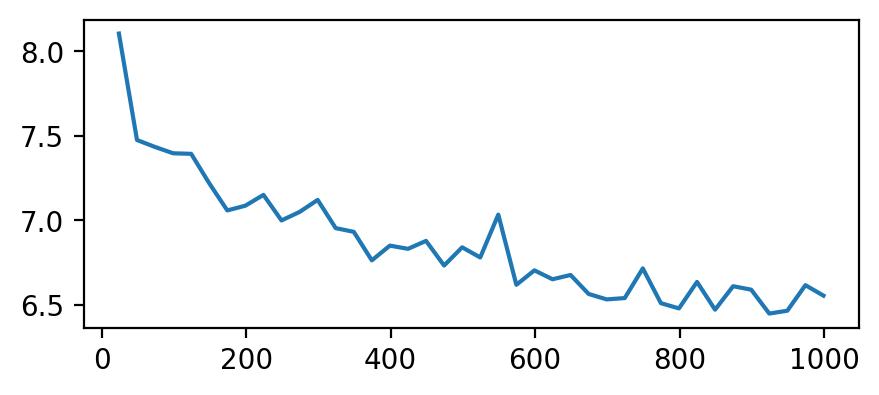

Iter 2048: Train loss 6.364, It/sec 1.4880    


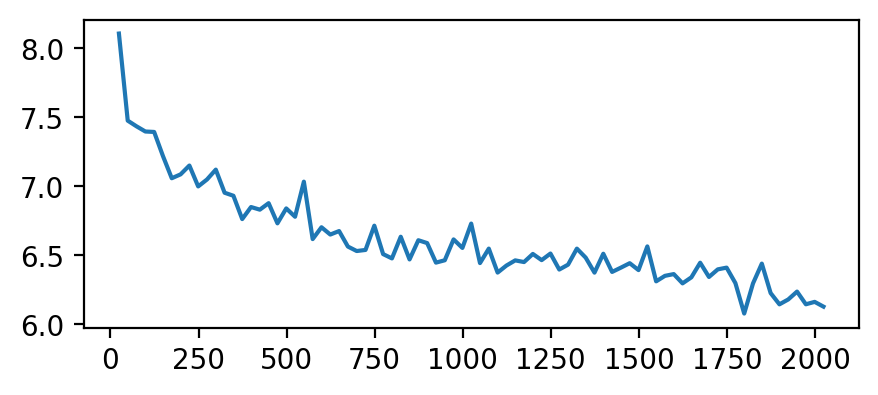

KeyboardInterrupt: 

In [22]:
train(reset_model = False)

In [ ]:
txt = generate_sample(model, td, prompt="At the beginning of time ", pad=True, temperature=0.7)
print(f"Res: {txt}")